# Translation with Transformer

- Download Dataset

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [11]:
import pandas as pd

In [5]:
from exp.nb_12a import *

In [2]:
from pathlib import Path
trg_path = Path('/gdrive/Shareddrives/Dion-Account/data')

In [6]:
trg_path.ls()

[PosixPath('/gdrive/Shareddrives/Dion-Account/data/giga-fren.tgz'),
 PosixPath('/gdrive/Shareddrives/Dion-Account/data/giga-fren')]

In [ ]:
# !wget https://s3.amazonaws.com/fast-ai-nlp/giga-fren.tgz -P {trg_path}

--2021-12-21 01:32:47--  https://s3.amazonaws.com/fast-ai-nlp/giga-fren.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.78.142
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.78.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2598183296 (2.4G) [application/x-tar]
Saving to: ‘/gdrive/Shareddrives/Dion-Account/data/giga-fren.tgz’

giga-fren.tgz       100%[===================>]   2.42G  35.7MB/s    in 77s     

2021-12-21 01:34:05 (32.0 MB/s) - ‘/gdrive/Shareddrives/Dion-Account/data/giga-fren.tgz’ saved [2598183296/2598183296]



In [ ]:
# !tar -xf {trg_path}/giga-fren.tgz -C {trg_path}

In [13]:
path = trg_path/'giga-fren'

In [ ]:
# with open(path/'giga-fren.release2.fixed.fr') as f: fr = f.read().split('\n')
# with open(path/'giga-fren.release2.fixed.en') as f: en = f.read().split('\n')
# import re
# re_eq = re.compile('^(Wh[^?.!]+\?)')
# re_fq = re.compile('^([^?.!]+\?)')
# lines = ((re_eq.search(eq), re_fq.search(fq))
#     for eq, fq, in zip(open(path/'giga-fren.release2.fixed.fr'), open(path/'giga-fren.release2.fixed.fr')))
# qs = [(e.group(), f.group()) for e, f in lines if e and f]
# import pandas as pd
# df = pd.DataFrame({'fr':[ q[1] for q in qs], 'en': [q[0] for q in qs]}, columns = ['en', 'fr']) 
# df.to_csv(path/'question_easy.csv', index=False)

In [14]:
df_load = pd.read_csv(path/'question_easy.csv')

In [15]:
df_load.head()

,en,fr
0,What's at Stake for Developing Countries?,What's at Stake for Developing Countries?
1,What is the solution?,What is the solution?
2,Which of the following thoughts are likely to ...,Which of the following thoughts are likely to ...
3,Why does it always have to be my fault?,Why does it always have to be my fault?
4,Why can't she leave this alone?,Why can't she leave this alone?


In [16]:
import torch

### Positional Encoding

$$PE(pos,2i) =sin(pos/10000^{2i/d_{model}})$$  
$$PE(pos,2i+1) =cos(pos/10000^{2i/d_{model}})$$

In [21]:
from torch import nn

In [43]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model:int):
        super().__init__()
        self.register_buffer('freq', 1/(10000 ** (torch.arange(0, d_model, 2.)/d_model)))
    def __call__(self, pos):
        inp = torch.outer(pos, self.freq)
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc

In [50]:
positions = torch.arange(0, 100).float(); positions[:10]
d_model = 26 

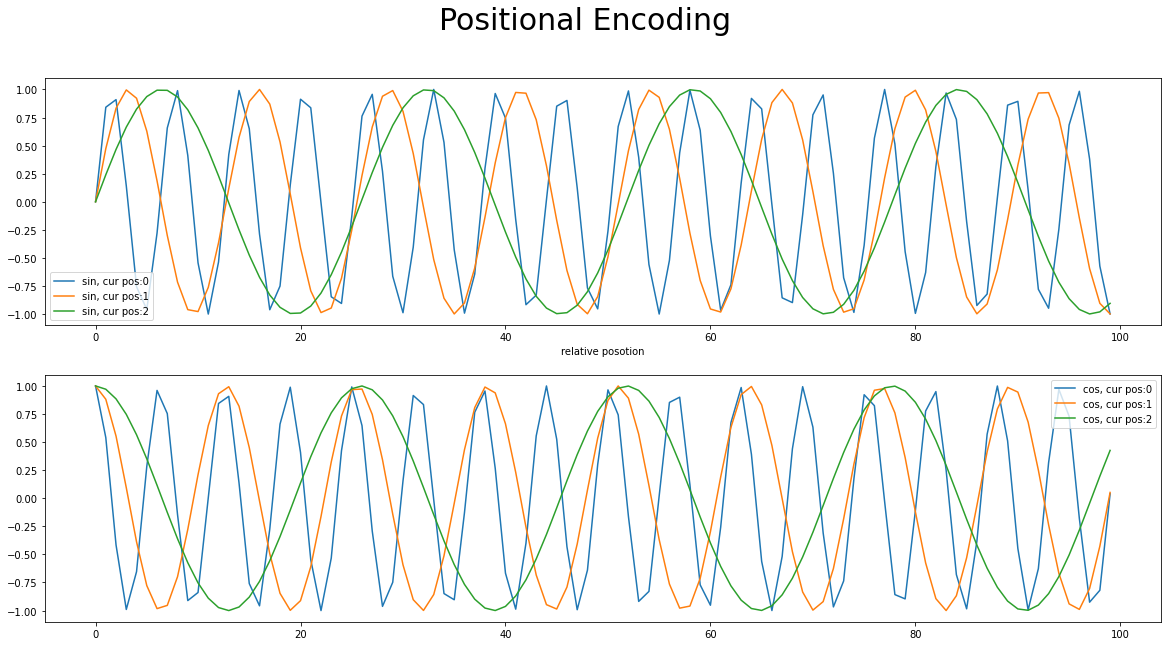

In [57]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1, figsize=(20,10))
fig.suptitle("Positional Encoding", fontsize=30)

res = PositionalEncoding(d_model=d_model)(positions)
for i in range(0,3):
    ax[0].plot(res[:,i], label=f"sin, cur pos:{i}")
    ax[0].legend()
    ax[0].set_xlabel("relative posotion")
    ax[1].plot(res[:,int(d_model/2+i)], label=f"cos, cur pos:{i}"); ax[1].legend()


## TransformerEmbedding

In [61]:
import math

class TransformerEmbedding(nn.Module):
    def __init__(self, vocab_size:int, emb_size:int, drop_p:float=0.):
        self.emb_size = emb_size
        self.embed = nn.Embedding(vocab_size, emb_size)
        self.pos_enc = PositionalEncoding(emb_size)
        self.dropout = nn.Droupout(drop_p)
        
    def forward(self, input):
        "input : sequence of indices of input sentence. e.g., [54, 23, 43, 12, 4, 4, 892, ...]"
        pos = torch.arange(0, input.size(1), device=input.device)
        return self.dropout(self.embed(input) * math.sqrt(self.emb_size) + self.pos_enc(pos))